In [2]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
import pathlib
import os


# Importing Dataset  
Download the Dataset by running the below cell

In [47]:

data_dir = tf.keras.utils.get_file(
    "dataset.zip",
    "https://github.com/axelooc59/Detecting-type-of-sneakers-shoes-by-ML-/blob/master/CV_SNKRS/data.zip",
    extract=False)

import zipfile
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')


..\CV_SNKRS\data
c:\Users\axgontie\Desktop\axel_gontier\personnal Github\CV_SNKRS\data


## Preprocessing our dataset using keras function



In [48]:

data_dir = pathlib.Path('../CV_SNKRS/data')
print(data_dir)
print(os.path.abspath(data_dir))
batch_size = 3
img_height = 200
img_width = 200


We define batch_size as 3 because our dataset it's quite small and a common size for each picture

We split our dataset into two dataset one for training which contains 80% of our data and the second in order to validation






In [53]:

#training set
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=20,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )
#validation set
val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=20,
  image_size=(img_height, img_width),
  batch_size=batch_size,shuffle=True)

  

class_names = val_data.class_names
print(val_data.class_names)







Found 711 files belonging to 7 classes.
Using 569 files for training.
Found 711 files belonging to 7 classes.
Using 142 files for validation.
['dunk_high', 'dunk_low', 'j1_high', 'j1_low', 'j1_mid', 'j3', 'j4']


## Display of one of the train batch 

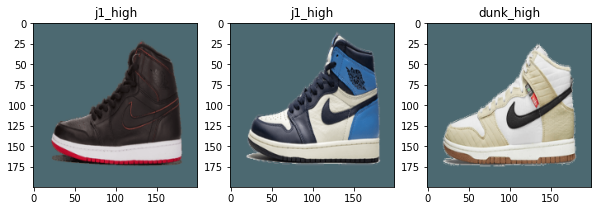

In [57]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    
    

## Writing convolutional Neural Network (CNN)

In [7]:
from tensorflow.keras import layers

def create_model() :
    num_classes = 7
    model = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),# input shape
    layers.experimental.preprocessing.Rescaling(1./255), #rescaling value between 0 and 1
    layers.Conv2D(128,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64,activation='relu'), #output shape
    layers.Dense(num_classes, activation='softmax')# convert probabilities of belonging for each class 
    ])
    return model
model=create_model()
print(model.summary())


12
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 197, 197, 128)     6272      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 95, 95, 64)        131136    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 32)      

### Training our model with trainSet

In [8]:

#configuration training 
model.compile(optimizer='adam', # Optimizer

              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),# Loss function to minimize

  metrics=['accuracy'],) #List of metrics to monitor


logdir="logs"

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_images=logdir,
                                                   embeddings_data=train_data)

# Fit model on training data and use validation set
# train for 2 epochs on a batch_size of 3
history=model.fit( 
  train_data,
  validation_data=val_data,
  epochs=2,
  
  callbacks=[tensorboard_callback]
)
model.summary()
model.save('model_CNN')#saving our model


## Learning curves

In [9]:
def plot_learning_curves(history, parameter):

    plt.plot(history.history[parameter])
    plt.plot(history.history['val_'+parameter])
    plt.xlabel("Epochs")
    plt.ylabel(parameter)
    plt.legend([parameter, 'validation '+parameter])
    plt.show()


plot_learning_curves(history, "loss")
plot_learning_curves(history, "accuracy")


NameError: name 'history' is not defined

both metrics are toward the same direction, everything is fine. It's seemed there is no overfitting.  
We have saved our model in order to not train everytime we want to use it.

In [10]:
model = keras.models.load_model('model_CNN')
model.summary()


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_21 (Rescaling)    (None, 200, 200, 3)       0         
                                                                 
 conv2d_84 (Conv2D)          (None, 197, 197, 128)     6272      
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 98, 98, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_85 (Conv2D)          (None, 95, 95, 64)        131136    
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 47, 47, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_86 (Conv2D)          (None, 44, 44, 32)      

## Evaluation of the model

In [11]:
loss,acc= model.evaluate(val_data)



C:\Users\axgontie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


48/48 [==============================] - 4s 72ms/step - loss: 0.1599 - accuracy: 0.9366


We have got 88.73 % accuracy over the validation set.

## Some predictions

In [42]:

val= tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=20,
  image_size=(img_height, img_width),
  batch_size=142,shuffle=True)




Found 711 files belonging to 7 classes.
Using 142 files for validation.


## Display of prediction on the validation set

1/1 [==============================] - 0s 41ms/step


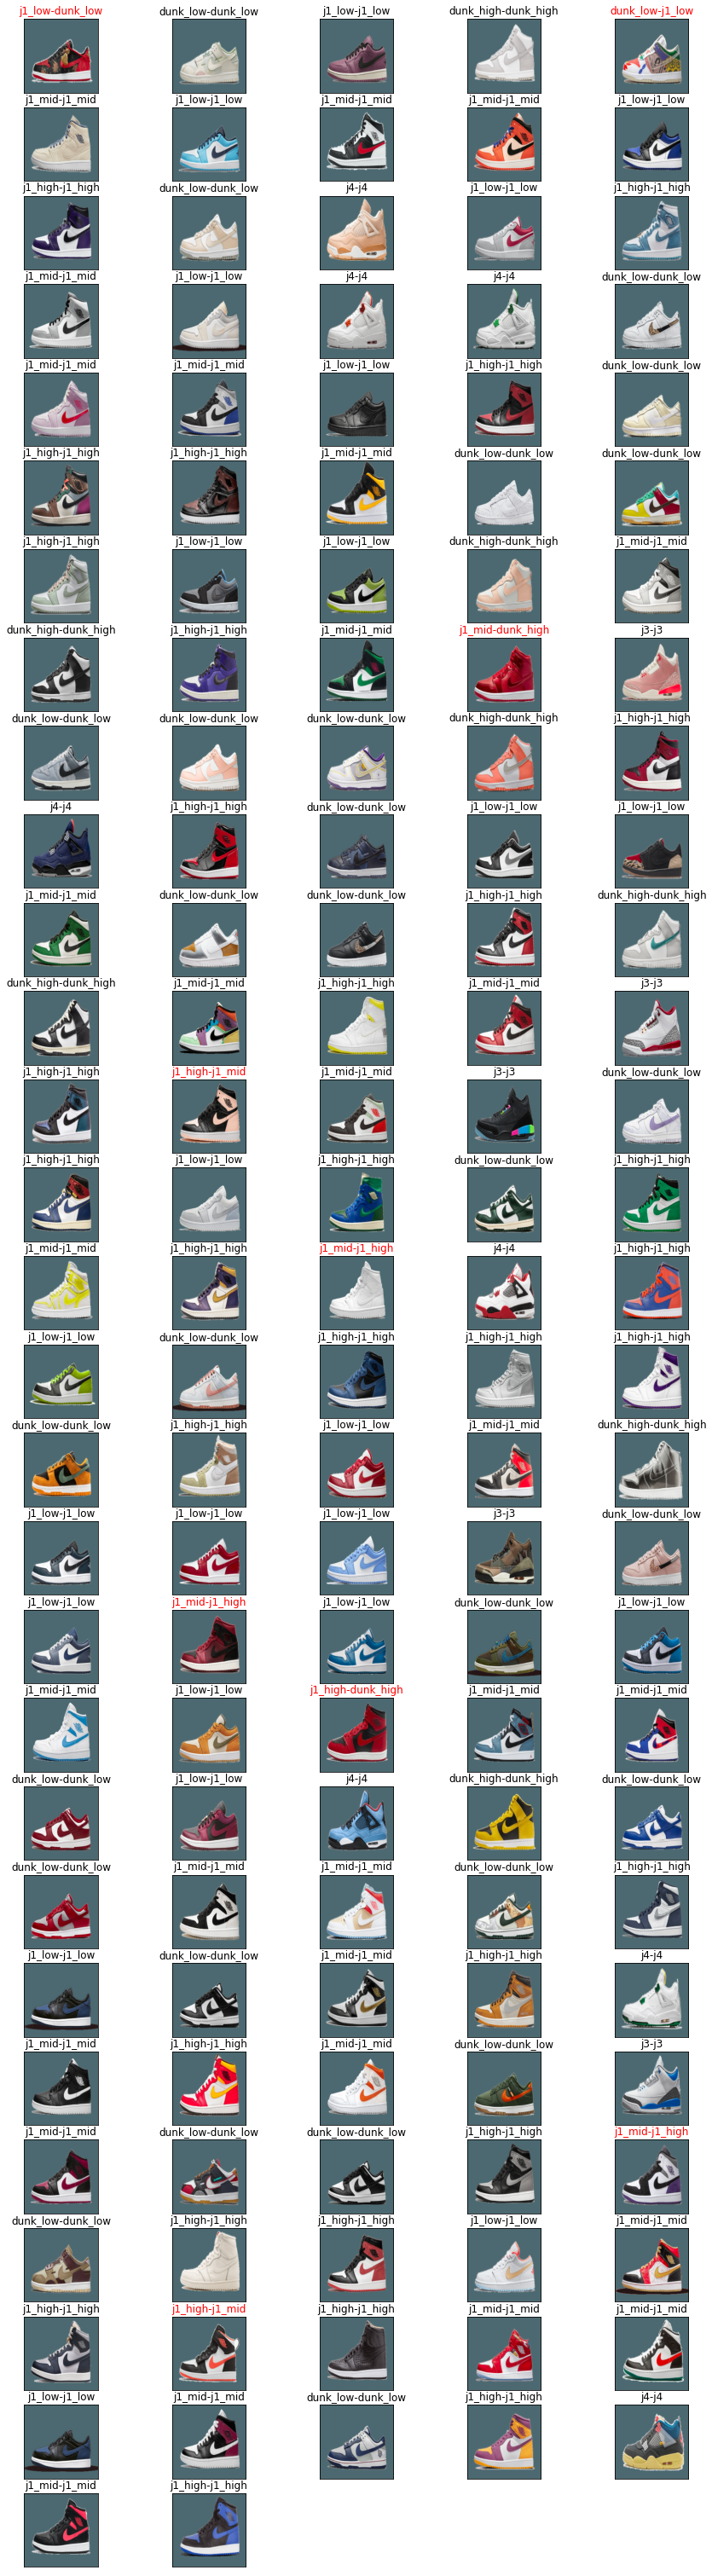

accurancy: 0.94


In [43]:

LEN=142 #len of the validation set
INCORRECT=0
for images,labels in  val.take(1):
    plt.figure(figsize=(15,50))
    plt.subplots_adjust(bottom=0.05)
    
    for i in range(142):
        ax=plt.subplot(29,5,i+1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        plt.imshow(images[i].numpy().astype("uint8"))
        img_to_predict = np.expand_dims(cv2.resize(images[i].numpy().astype("uint8"),(200,200)), axis=0) 
        res1 = model.predict(img_to_predict)
        res=np.argmax(res1)  
        if(class_names[labels[i]]!=val_data.class_names[res]):
            plt.title(class_names[labels[i]]+"-"+val_data.class_names[res], color='red')
            INCORRECT+=1
        else:
            plt.title(class_names[labels[i]]+"-"+val_data.class_names[res])
        plt.axis="off"
    plt.show()
    
    print("accurancy: "+str(1 - round(INCORRECT/LEN,2)))


